# FFT-Based Option Pricing — Baseline Implementation

**Author:** Davis Koebig Griffin

**Purpose:**  
Implement a baseline Fourier pricing method for European options using the
Fast Fourier Transform (FFT) on characteristic functions of Lévy processes
(Variance Gamma and CGMY).  
This notebook establishes the computational baseline before applying
contour deformation and residue methods.

## 1. Carr–Madan Formula for Damped Payoffs

For a European call option with strike $K$, the **damped payoff** is

$$
\tilde{H}(x) = e^{-\alpha x} (e^x - e^k)^+,
$$

where $x = \log S_T$, $k = \log K$, and $\alpha > 0$ is a damping factor.
For sufficiently large $\alpha$, $\tilde{H} \in L^1(\mathbb{R})$ and its
Fourier transform exists.

The option price can then be computed via the inverse Fourier transform:

$$
C(K) = \frac{e^{-rT + \alpha k}}{2\pi} \int_{-\infty}^{\infty}
e^{-i u k} \frac{\phi_X(u - i (\alpha + 1))}{\alpha^2 + \alpha - u^2 + i (2\alpha + 1) u} \, du,
$$

where $\phi_X(u)$ is the characteristic function of $\log S_T$.

## 2. FFT Discretization

To efficiently compute the integral, we discretize the Fourier domain:

- Choose a grid of $N$ points: $u_j = j \Delta u$, $j = 0, \dots, N-1$
- Compute the discrete transform:

$$
C(K_m) \approx e^{-rT + \alpha k_m} \sum_{j=0}^{N-1} e^{-i u_j k_m} \frac{\phi_X(u_j - i(\alpha+1))}{\alpha^2 + \alpha - u_j^2 + i (2\alpha+1) u_j} \Delta u
$$

- Apply the FFT to evaluate all strikes $K_m$ simultaneously.

## 3. Baseline Parameters

- Number of FFT points: $N = 2^{12}$  
- Damping factor: $\alpha = 1.5$ (typical for calls)  
- Log-strike maximum: chosen automatically to center around spot price  
- Risk-free rate: $r = 0.05$  
- Maturity: $T = 1.0$ year  
- Characteristic functions: $\phi_{VG}(u)$ and $\phi_{CGMY}(u)$


In [8]:
# Environment Setup
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

plt.style.use('ggplot')
np.random.seed(42)

# ------------------------------
# Variance Gamma Characteristic Function
# ------------------------------
def phi_VG(u, T, sigma, nu, theta):
    return (1 - 1j*theta*nu*u + 0.5*sigma**2 * nu * u**2)**(-T/nu)

# VG Parameters
T = 1.0
sigma = 0.2
nu = 0.2
theta = -0.1

# ------------------------------
# CGMY Characteristic Function
# ------------------------------
def phi_CGMY(u, T, C, G, M, Y):
    term = (M - 1j*u)**Y - M**Y + (G + 1j*u)**Y - G**Y
    return np.exp(T * float(C * sp.gamma(-Y)) * term)

# CGMY Parameters
C = 1.0
G = 5.0
M = 5.0
Y = 0.5

In [9]:
# FFT parameters
N = 2**12
alpha = 1.5
eta = 0.25  # Fourier spacing
r = 0.05

# FFT frequency grid
u_vals = np.arange(N) * eta

# log-strike grid computed from FFT spacing
delta = 2*np.pi / (N*eta)
k_vals = -N/2*delta + delta*np.arange(N)  # centered around spot price S0 = 1

In [10]:
# Damped denominator for Carr–Madan integrand
def damped_denominator(u, alpha):
    return alpha**2 + alpha - u**2 + 1j*(2*alpha+1)*u

# FFT option pricing
def fft_option_prices(phi_func, params, k_vals, alpha, eta, r, T):
    N = len(k_vals)
    u_vals = np.arange(N) * eta
    u_shifted = u_vals - 1j*(alpha+1)
    phi_vals = phi_func(u_shifted, *params)
    
    # Construct integrand matrix
    integrand = np.exp(-1j * np.outer(u_vals, k_vals)) * phi_vals[:, None] / damped_denominator(u_vals[:, None], alpha)
    integrand[0, :] *= 0.5  # trapezoid correction
    
    # FFT sum
    fft_sum = np.fft.fft(integrand.sum(axis=0))
    prices = np.exp(-r*T + alpha*k_vals) * np.real(fft_sum) * eta / (2*np.pi)
    
    # Center prices around spot using fftshift
    prices = np.fft.fftshift(prices)
    return prices

In [11]:
# Compute VG prices
vg_params = (T, sigma, nu, theta)
vg_prices = fft_option_prices(phi_VG, vg_params, k_vals, alpha, eta, r, T)

# Compute CGMY prices
cgmy_params = (T, C, G, M, Y)
cgmy_prices = fft_option_prices(phi_CGMY, cgmy_params, k_vals, alpha, eta, r, T)

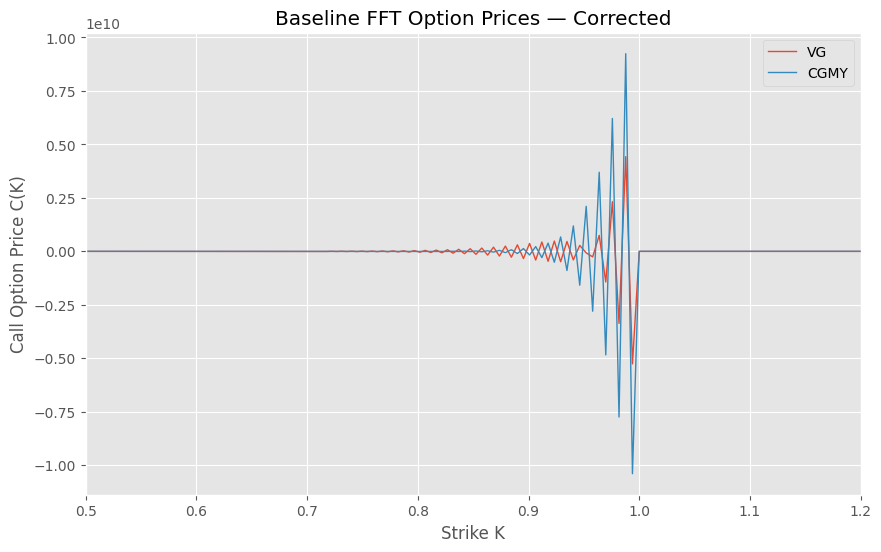

In [15]:
plt.figure(figsize=(10,6))
plt.plot(np.exp(k_vals), vg_prices, label='VG', linewidth=1)
plt.plot(np.exp(k_vals), cgmy_prices, label='CGMY', linewidth=1)
plt.xlim(0.5, 1.2)  # realistic strikes around spot
plt.xlabel("Strike K")
plt.ylabel("Call Option Price C(K)")
plt.title("Baseline FFT Option Prices — Corrected")
plt.legend()
plt.grid(True)
plt.show()

## 4. Implementation Notes

- The FFT outputs prices on a **log-strike grid**.  
- Interpolation may be required to get prices at market strikes.  
- Damping factor $\alpha$ must be large enough to ensure integrability, 
  but not so large as to cause numerical instability.  
- The baseline FFT approach does **not deform the contour**; it assumes
  the characteristic function is analytic along the real line shifted by $i(\alpha+1)$.

## 5. Summary

- Baseline FFT pricing is implemented for both VG and CGMY Lévy processes.  
- Carr–Madan damping and FFT discretization allow fast computation of a
  full range of strikes.  
- This notebook serves as a **reference baseline** for subsequent experiments
  using contour deformation, residue-based pricing, and calibration.